In [1]:
## Options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#commodity_rate = 0.047 # Chilled Water (tonh)
commodity_rate = 0.065 # Electricity (kWh)
#commodity_rate = (1.0/1000*6) # Steam (klb)

In [3]:
## Imports

## Mac imports
import sys
toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
sys.path.append(toolPath)

## Main Imports

import mnv13 as mnv
print(mnv.version)

from PI_client import pi_client
pi = pi_client()
print("Success!")

/Users/decolvin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Version 1.3
Success!


### Local Data Loading

In [4]:
# filePath = 'data/OATtest.xlsx'
#filePath = r'/Users/decolvin/Downloads/GBSF Data 061318.csv'
#filePath = 'data/arc2yeardata.xlsx'
#data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True)
#data = pd.read_csv(filePath, header=0, index_col=0, parse_dates=True)
#print(data.columns)

### PI Data Loading

In [5]:
tags = pi.search_by_point('*shrem*/*demand')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

tags

[u'Shrem_Museum_of_Art_ATS-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_CCP-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_CCP-1B/Electricity_Demand',
 u'Shrem_Museum_of_Art_CCP-1C/Electricity_Demand',
 u'Shrem_Museum_of_Art_DPL-MA/Electricity_Demand',
 u'Shrem_Museum_of_Art_DPL-RA/Electricity_Demand',
 u'Shrem_Museum_of_Art_ECCP-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_ELP-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_ELP-1B/Electricity_Demand',
 u'Shrem_Museum_of_Art_LP-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_LP-1B/Electricity_Demand',
 u'Shrem_Museum_of_Art_LP-1C/Electricity_Demand',
 u'Shrem_Museum_of_Art_LP-1D/Electricity_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Chilled_Water_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Domestic_Water_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Gas_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Heating_Hot_Water_Demand']

#### Pull tags

In [10]:
tags_selected = ['Shrem_Museum_of_Art_MS-1A/Chilled_Water_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Electricity_Demand',
 u'Shrem_Museum_of_Art_MS-1A/Gas_Demand']

startDate = '2017-01-01'
endDate = '*'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

data = pi.get_stream_by_point(tags_selected, start=startDate, end=endDate, interval=interval, calculation=calculation)

<Response [200]>
<Response [200]>
<Response [200]>


In [11]:
## Imports

## Mac imports
# import sys
# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

## Main Imports
import mnv13 as mnv
print(mnv.version)
import matplotlib.pyplot as plt
print("Success!")

Version 1.3
Success!


# Data Section

In [12]:
data.head()

,Shrem_Museum_of_Art_MS-1A/Chilled_Water_Demand,Shrem_Museum_of_Art_MS-1A/Electricity_Demand,Shrem_Museum_of_Art_MS-1A/Gas_Demand
2017-01-01 00:00:00,3.417687,57.173503,7.496234
2017-01-01 01:00:00,NaN,58.833988,7.507229
2017-01-01 02:00:00,NaN,55.030175,7.504517
2017-01-01 03:00:00,NaN,53.926951,7.500733
2017-01-01 04:00:00,NaN,54.568057,7.504153


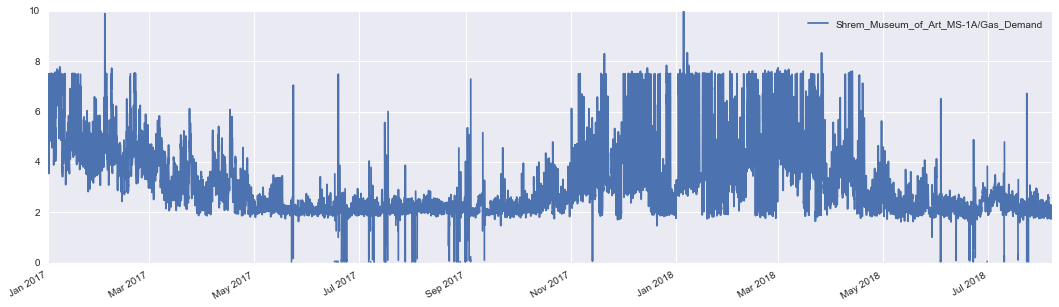

In [13]:
data.iloc[:,2].plot(figsize=(18,5), legend=True)
plt.show()

Q(75%): 3.67 Q(25%): 2.17
IQR value is 1.51
Ceiling adjusted by IQR - Now 8.19


/Users/decolvin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


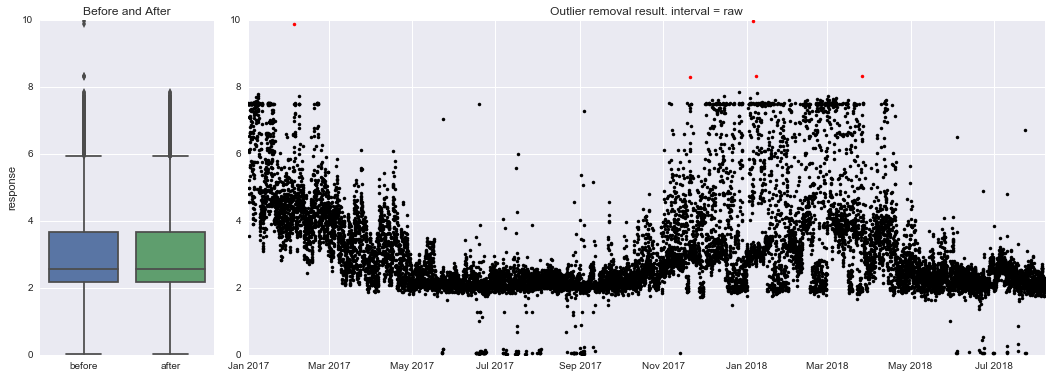

Deprecation warning: this function should be called calculate_degree_hours(). Use that name instead
OAT being loaded from master file


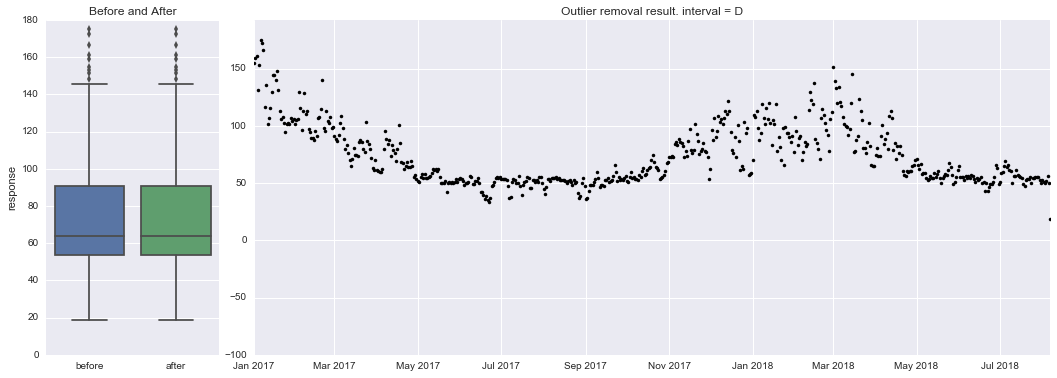

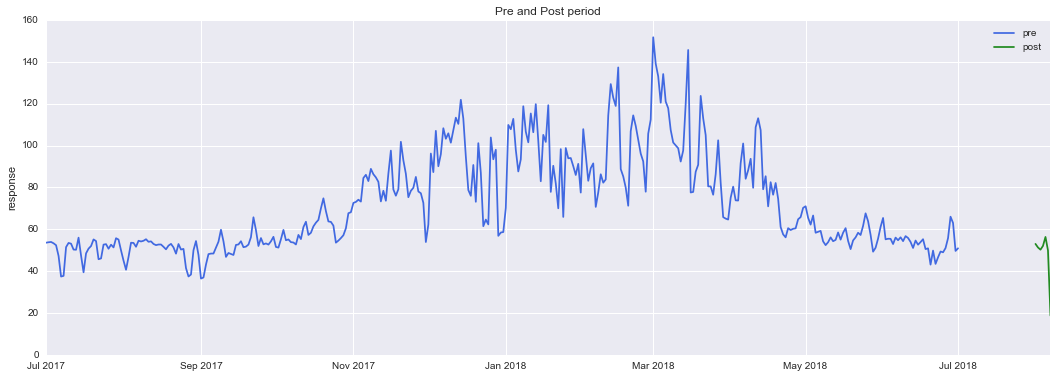

In [14]:
data = data.copy()
data.rename(columns={data.columns[2]:"response"},inplace=True)

inputDict = {'IQRmult' : 3.0,
             'IQR' : 'y', 
             'resampleRate' : 'D', #'D' for daily 'H' for hourly
             'verbosity' : 3,
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2017-07-01','2018-07-01','2018-08-01','2018-08-08'], #only needed with sliceType : 'ranges'
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data['response'], inputDict)
dc.default_clean()

dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1))
## Run the next line incase the y-range is FUBAR
#dc._resampled_plot()

# plot 3
dc._pre_post_plot()

# Many Linear Models

In [15]:
dc.pre.columns

Index([u'response', u'HDH', u'CDH', u'HDH2', u'CDH2', u'year', u'month', u'dayofmonth', u'hour', u'minute', u'dayofweek', u'weekofyear', u'daytime', u'weekday', u'saturday', u'sunday'], dtype='object')

[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
[]
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
['weekday']
['month']
['weekday']
['month']
['month', 'weekday']
        AIC       AR2        R2    cvrmse postDiff                              params                                            summary
22  2265.32  0.770682  0.781715    0.1584      NaN   CDH + HDH + C(weekday) + C(month)                              OLS Regression Res...
23  2275.34  0.729418  0.740576  0.161665      NaN                      HDH + C(month)                             

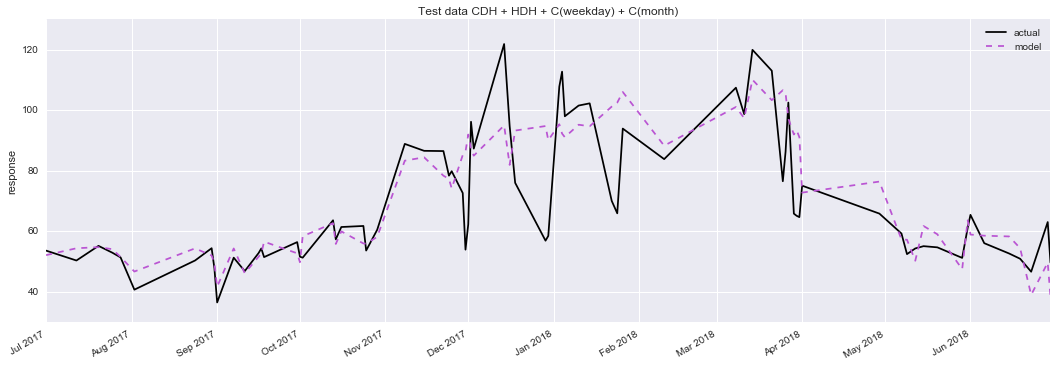

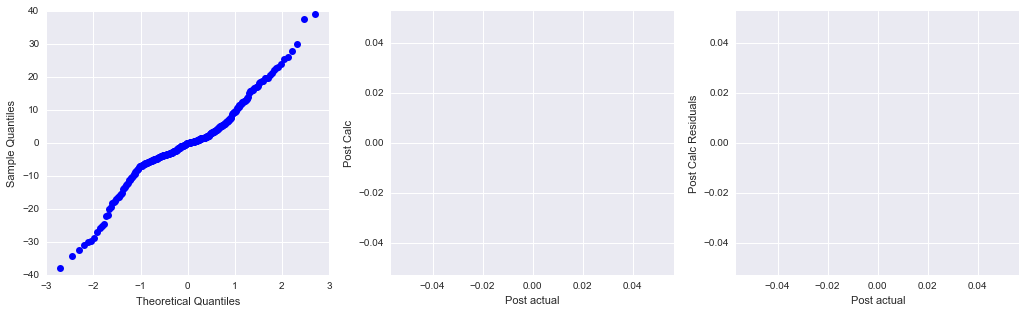

In [16]:
modelDict = {'params': ['CDH','HDH','month','hour','weekday'],
             'testTrainSplit': 'random',
             'randomState': None,
             'testSize': 0.2,
             'commodityRate': commodity_rate,
             'paramList': ['', 'C(weekday)', 'C(month)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(1)
modelDict['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

['month', 'weekday']
(0.2, 'nfolds', 5)
['month', 'weekday']
             VIF
const  42.641221

Kfold
         R2       AR2         mse
3  0.749652  0.737045  136.186961
4  0.757834  0.745638  139.471462
1  0.755082  0.742748  139.652692
0  0.760921  0.748837  143.355814
2  0.741503  0.728485  146.712235

3       96.586497
4       98.915930
1       99.044462
0      101.670790
2      104.051230
mse    141.000000
dtype: float64


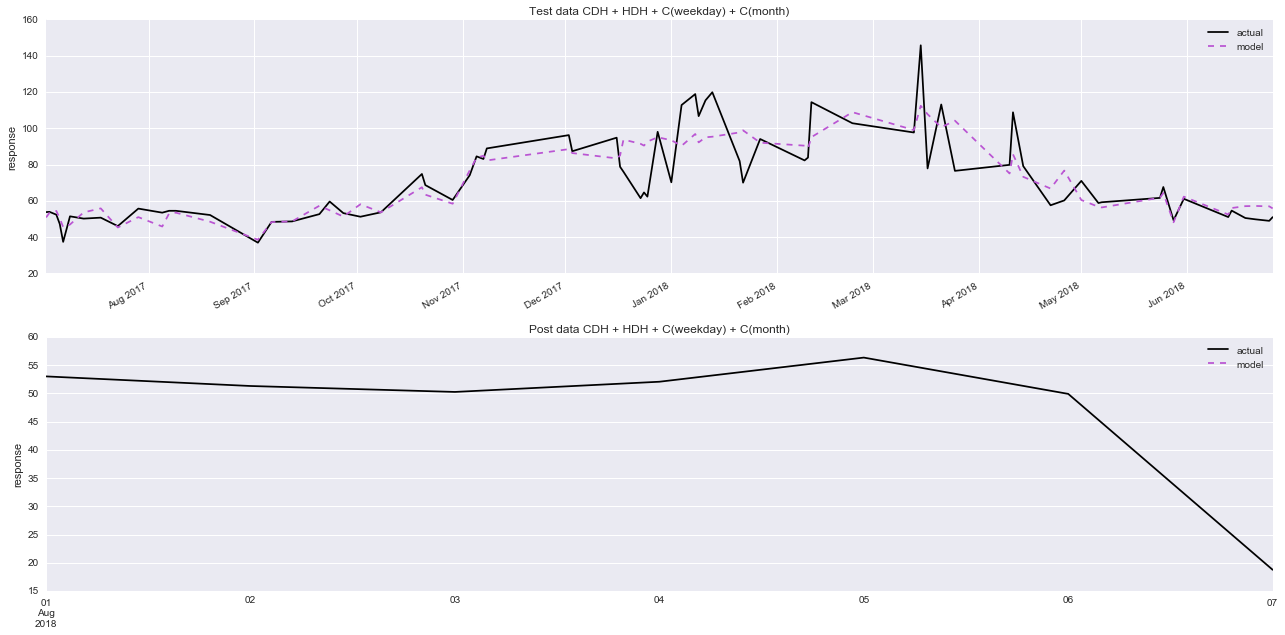

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     63.57
Date:                Tue, 07 Aug 2018   Prob (F-statistic):           7.12e-78
Time:                        09:50:21   Log-Likelihood:                -1124.0
No. Observations:                 292   AIC:                             2278.
Df Residuals:                     277   BIC:                             2333.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          76.3164      4.458     17.119      0.000      67.541      85.092
C(weekday)[T.1]     3.7305      1.561      2.391      0.017       0.658       6.803
C(month)[T.2]       5.4415      3.464      1.571      0.117      -1.378      12.261
C(month)[T.3]      11.9059      3.470      3.431      0.001       5.074      18.738
C(month)[T.4]      -6.2800      3.836     -1.637      0.103     -13.832       1.272
C(month)[T.5]     -21.5858      4.258     -5.069      0.000     -29.968     -13.203
C(month)[T.6]     -18.2644      4.738     -3.855      0.000     -27.592      -8.937
C(month)[T.7]     -18.6828      5.165     -3.617      0.000     -28.851      -8.515
C(month)[T.8]     -21.2499      4.894     -4.342      0.000     -30.884     -11.615
C(month)[T.9]     -20.7792      4.753     -4.372      0.000     -30.136     -11.422
C(month)[T.10]    -20.3033      4.187     -4.849      0.000     -28.546     -12.060
C(month)[T.11]     -8.6848      3.610     -2.405      0.017     -15.792      -1.577
C(month)[T.12]     -3.5253      3.555     -0.992      0.322     -10.524       3.474
CDH                -0.0321      0.010     -3.071      0.002      -0.053      -0.012
HDH                 0.0505      0.011      4.518      0.000       0.029       0.073
==============================================================================
Omnibus:                       20.710   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.233
Skew:                          -0.209   Prob(JB):                     1.37e-13
Kurtosis:                       5.167   Cond. No.                     3.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()

mod.kfold()
mod.calculate_vif()

print(mod.vif[mod.vif['VIF'] > 10])

print('\nKfold')
print(mod.kfoldStats)
print
print(mod.kfoldRelative)

plt.show() # Show plot before Stats summary
mod.Fit.summary()

### Savings

Savings = $nan


/Users/decolvin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


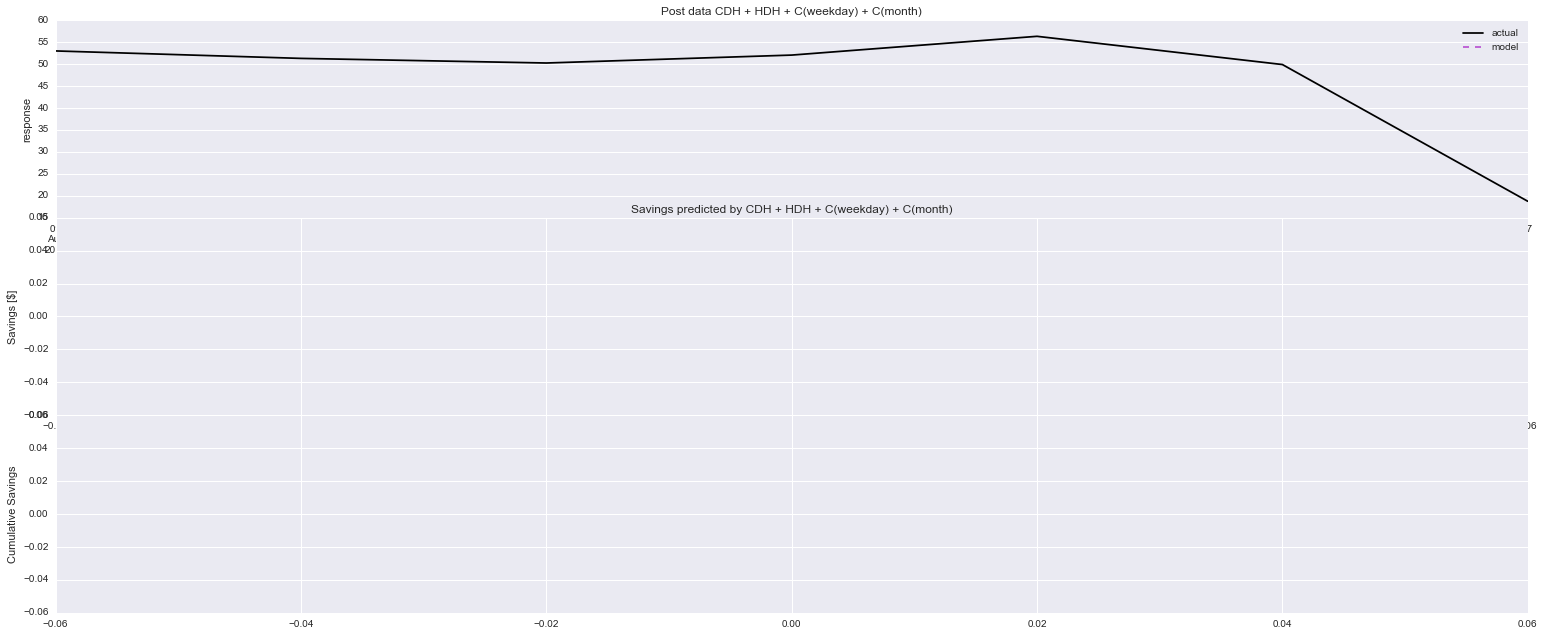

In [18]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'
savings = round(mod.postCumsum * mod.params.commodityRate,1)
print("Savings = $" +str(savings))
mod.savings_plot(yaxis='dollars')

# Estimate FY Savings

In [ ]:
per_day = savings / len(mod.postDiff)
print("Estimated FY Savings = $%.0f") %(per_day * 365)